# AI-Powered Crop Yield Prediction for Odisha

### **Project Goal for Hackathon**

The objective of this project is to develop a high-performance machine learning model that accurately predicts crop yield in Odisha. We will follow a structured workflow to ingest, clean, explore, and model the provided agricultural, weather, soil, and irrigation datasets. The final output will be a trained and saved model, ready for deployment in a web application.

**Workflow:**
1.  **Setup:** Import necessary libraries.
2.  **Data Loading & Cleaning:** Load all data sources and merge them into a single, clean master dataset.
3.  **Exploratory Data Analysis (EDA):** Visualize data to uncover initial insights and correlations.
4.  **Feature Preprocessing:** Prepare the data for machine learning models.
5.  **Model Training & Comparison:** Train four powerful models and identify the best performer.
6.  **Analysis & Interpretation:** Analyze the best model to understand which factors most influence crop yield.
7.  **Model Saving:** Save the final model for deployment.

In [23]:
# --- Core Libraries for Data Handling ---
import pandas as pd
import numpy as np
import time
import pickle

# --- Libraries for Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Libraries for Machine Learning ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import r2_score, mean_absolute_error

# --- Configure plot styles for a professional look ---
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries imported successfully.")

All libraries imported successfully.


In [ ]:
# Load the datasets
try:
    apy_df = pd.read_csv('odisha_data/merged_apy_data.csv')
    soil_df = pd.read_csv('odisha_data/odisha_soil_data.csv')
    irrigation_df = pd.read_csv('odisha_data/odisha_irrigation_data.csv')
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure the file paths are correct.")
    # Create empty dataframes to avoid further errors
    apy_df = pd.DataFrame()
    soil_df = pd.DataFrame()
    irrigation_df = pd.DataFrame()

In [2]:
# --- Data Exploration ---
print("--- Initial Data Exploration ---")

# Explore merged_apy_data.csv
if not apy_df.empty:
    print("\n--- merged_apy_data.csv ---")
    print("Shape:", apy_df.shape)
    print("\nInfo:")
    apy_df.info()
    print("\nMissing Values:")
    print(apy_df.isnull().sum())
    print("\nDuplicates:", apy_df.duplicated().sum())
    print("\nUnique Crops:", apy_df['Crop'].nunique())
    print("Unique Districts:", apy_df['District_Name_x'].nunique())

# Explore odisha_soil_data.csv
if not soil_df.empty:
    print("\n--- odisha_soil_data.csv ---")
    print("Shape:", soil_df.shape)
    print("\nInfo:")
    soil_df.info()
    print("\nMissing Values:")
    print(soil_df.isnull().sum())
    print("\nDuplicates:", soil_df.duplicated().sum())
    # Standardize district names for merging
    soil_df['District'] = soil_df['District'].str.upper().str.strip()


# Explore odisha_irrigation_data.csv
if not irrigation_df.empty:
    print("\n--- odisha_irrigation_data.csv ---")
    print("Shape:", irrigation_df.shape)
    print("\nInfo:")
    irrigation_df.info()
    print("\nMissing Values:")
    print(irrigation_df.isnull().sum())
    print("\nDuplicates:", irrigation_df.duplicated().sum())
    # Standardize district names for merging
    irrigation_df['District'] = irrigation_df['District'].str.upper().str.strip()

--- Initial Data Exploration ---

--- merged_apy_data.csv ---
Shape: (7227, 14)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7227 entries, 0 to 7226
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   State            7227 non-null   object 
 1   District_Name_x  7227 non-null   object 
 2   Crop             7227 non-null   object 
 3   Year             7227 non-null   int64  
 4   Season_x         7227 non-null   object 
 5   Area             7227 non-null   float64
 6   Production       7199 non-null   float64
 7   Yield            7227 non-null   float64
 8   Season_y         7227 non-null   object 
 9   avg_temp         7227 non-null   float64
 10  max_temp         7227 non-null   float64
 11  min_temp         7227 non-null   float64
 12  total_rainfall   7227 non-null   float64
 13  District_Name_y  7227 non-null   object 
dtypes: float64(7), int64(1), object(6)
memory usage: 790.6+ KB

Missi

In [3]:
# --- Merging Datasets ---
print("\n--- Merging Datasets ---")

if not apy_df.empty and not soil_df.empty and not irrigation_df.empty:
    # Standardize district names in the main dataframe
    apy_df['District_Name_x'] = apy_df['District_Name_x'].str.upper().str.strip()

    # Merge with soil data
    merged_df = pd.merge(apy_df, soil_df, left_on='District_Name_x', right_on='District', how='left')
    print("\nShape after merging with soil data:", merged_df.shape)

    # Merge with irrigation data
    merged_df = pd.merge(merged_df, irrigation_df, left_on='District_Name_x', right_on='District', how='left')
    print("Shape after merging with irrigation data:", merged_df.shape)

    # --- Data Preprocessing ---
    print("\n--- Data Preprocessing ---")

    # Drop redundant columns
    merged_df.drop(['District_Name_y', 'Season_y', 'District_x', 'District_y'], axis=1, inplace=True, errors='ignore')

    # Rename columns for clarity
    merged_df.rename(columns={
        'District_Name_x': 'District',
        'Season_x': 'Season',
        'Net Ground Water Availability for future use (ham)': 'Ground_Water'
    }, inplace=True)

    # Handle missing values (if any)
    # For simplicity, we'll fill numerical NaNs with the mean. A more sophisticated approach might be better.
    for col in merged_df.select_dtypes(include=np.number).columns:
        if merged_df[col].isnull().any():
            print(f"Filling missing values in '{col}' with mean.")
            merged_df[col].fillna(merged_df[col].mean(), inplace=True)

    print("\nFinal shape of the merged and preprocessed dataframe:", merged_df.shape)
    print("\nColumns in the final dataframe:", merged_df.columns.tolist())
    print("\nFirst 5 rows of the final dataframe:")
    print(merged_df.head())

else:
    print("Could not proceed with merging and preprocessing due to missing initial dataframes.")



--- Merging Datasets ---

Shape after merging with soil data: (7227, 20)
Shape after merging with irrigation data: (7227, 22)

--- Data Preprocessing ---
Filling missing values in 'Production' with mean.
Filling missing values in 'N' with mean.
Filling missing values in 'P' with mean.
Filling missing values in 'K' with mean.
Filling missing values in 'pH' with mean.
Filling missing values in 'OC' with mean.
Filling missing values in 'Ground_Water' with mean.

Final shape of the merged and preprocessed dataframe: (7227, 18)

Columns in the final dataframe: ['State', 'District', 'Crop', 'Year', 'Season', 'Area', 'Production', 'Yield', 'avg_temp', 'max_temp', 'min_temp', 'total_rainfall', 'N', 'P', 'K', 'pH', 'OC', 'Ground_Water']

First 5 rows of the final dataframe:
    State District       Crop  Year       Season    Area  Production  Yield  \
0  Odisha   ANUGUL  Arhar/Tur  1997  Summer        469.0       115.0   0.25   
1  Odisha   ANUGUL  Arhar/Tur  1999  Kharif       7960.0      501

C:\Users\Abhi\AppData\Local\Temp\ipykernel_26396\944817291.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df[col].fillna(merged_df[col].mean(), inplace=True)


In [4]:
# Export the master dataset (merged_df) to CSV
print("Master Dataset Info:")
print(f"Shape: {merged_df.shape}")
print(f"Columns: {list(merged_df.columns)}")
print("\nFirst few rows:")
print(merged_df.head())

# Export the master dataset to CSV
output_file = "master_dataset_complete.csv"
merged_df.to_csv(output_file, index=False)
print(f"\nMaster dataset exported to: {output_file}")
print(f"File saved with {len(merged_df)} rows and {len(merged_df.columns)} columns.")

Master Dataset Info:
Shape: (7227, 18)
Columns: ['State', 'District', 'Crop', 'Year', 'Season', 'Area', 'Production', 'Yield', 'avg_temp', 'max_temp', 'min_temp', 'total_rainfall', 'N', 'P', 'K', 'pH', 'OC', 'Ground_Water']

First few rows:
    State District       Crop  Year       Season    Area  Production  Yield  \
0  Odisha   ANUGUL  Arhar/Tur  1997  Summer        469.0       115.0   0.25   
1  Odisha   ANUGUL  Arhar/Tur  1999  Kharif       7960.0      5010.0   0.63   
2  Odisha   ANUGUL  Arhar/Tur  2000  Kharif       8930.0      6430.0   0.72   
3  Odisha   ANUGUL  Arhar/Tur  2002  Kharif       8730.0      6050.0   0.69   
4  Odisha   ANUGUL  Arhar/Tur  2003  Kharif       9500.0      6500.0   0.68   

    avg_temp  max_temp  min_temp  total_rainfall          N          P  \
0  31.696393     45.56     18.99          135.95  21.132757  52.450741   
1  26.761830     41.06     16.73         1217.58  21.132757  52.450741   
2  26.927124     37.95     15.42          856.98  21.132757  5

In [24]:
# --- Step 1: Load the Master Dataset ---
try:
    merged_df = pd.read_csv('master_dataset_complete.csv')
    print("Step 1: Successfully loaded 'master_dataset_complete.csv'.\n")
except FileNotFoundError:
    print("Error: 'master_dataset_complete.csv' not found. Please ensure the file is in the correct directory.")
    exit()

Step 1: Successfully loaded 'master_dataset_complete.csv'.



In [25]:
# --- Step 2: Feature Preprocessing ---
print("Step 2: Preparing data for modeling...")

# Create a special copy for CatBoost
merged_df_catboost = merged_df.copy()
categorical_cols = ['District', 'Crop', 'Season']
for col in categorical_cols:
    merged_df_catboost[col] = merged_df_catboost[col].astype('category')

# Use Label Encoding for other models
for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])

# Define Features (X) and Target (y), dropping leaky/unnecessary columns
X = merged_df.drop(['Yield', 'Production', 'Area', 'State'], axis=1)
y = merged_df['Yield']
X_cat = merged_df_catboost.drop(['Yield', 'Production', 'Area', 'State'], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, test_size=0.2, random_state=42)

print("Data successfully preprocessed and split.\n")

Step 2: Preparing data for modeling...
Data successfully preprocessed and split.



In [26]:
# --- Step 3: Initialize Base and Ensemble Models ---
print("Step 3: Initializing all models...")

# Get categorical feature indices for CatBoost
cat_features_indices = [X_train_cat.columns.get_loc(col) for col in categorical_cols]

# Define our base models
cb_model = cb.CatBoostRegressor(n_estimators=100, random_state=42, verbose=0, cat_features=cat_features_indices)
lgbm_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Define the Voting Ensemble
voting_ensemble = VotingRegressor(
    estimators=[
        ('catboost', cb.CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)), # Cannot use pre-defined catboost due to data type difference
        ('lightgbm', lgbm_model),
        ('xgboost', xgb_model)
    ],
    n_jobs=-1
)

# Define the Stacking Ensemble
# It uses the base models to make predictions, and a meta-model to make the final prediction
estimators = [
    ('catboost', cb.CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)),
    ('lightgbm', lgbm_model),
    ('xgboost', xgb_model),
    ('random_forest', rf_model)
]

stacking_ensemble = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(), # Meta-model
    n_jobs=-1
)

# Consolidate all models into a dictionary for evaluation
models = {
    "CatBoost": cb_model,
    "LightGBM": lgbm_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Voting Ensemble": voting_ensemble,
    "Stacking Ensemble": stacking_ensemble
}

print("All base and ensemble models are ready.\n")

Step 3: Initializing all models...
All base and ensemble models are ready.



In [27]:
# --- Step 4: Train and Evaluate All Models ---
print("Step 4: Training and evaluating all models...")
results = {}
for name, model in models.items():
    print(f"--- Training {name} ---")
    start_time = time.time()
    
    # Use the specially prepared categorical dataset for CatBoost
    if name == "CatBoost":
        model.fit(X_train_cat, y_train_cat)
        y_pred = model.predict(X_test_cat)
    # Stacking and Voting regressors need the label-encoded data
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    end_time = time.time()
    
    # Store the performance metrics
    results[name] = {
        'R2 Score': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'Training Time (s)': end_time - start_time
    }

Step 4: Training and evaluating all models...
--- Training CatBoost ---
--- Training LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1244
[LightGBM] [Info] Number of data points in the train set: 5781, number of used features: 14
[LightGBM] [Info] Start training from score 1.136104
--- Training XGBoost ---
--- Training Random Forest ---
--- Training Voting Ensemble ---
--- Training Stacking Ensemble ---


In [28]:
# --- Step 5: Final Comparison and Saving the Best Model ---
print("\nStep 5: Comparing results and saving the champion model...")

# Display the final results in a clean, sorted DataFrame
results_df = pd.DataFrame(results).T.sort_values(by='R2 Score', ascending=False)
print("\n--- Final Model Performance Comparison ---")
print(results_df)

# Identify and save the single best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]

model_filename = f'{best_model_name.lower().replace(" ", "_")}_champion_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"\n✅ The champion model is: '{best_model_name}'")
print(f"It has been saved successfully as '{model_filename}' and is ready for deployment.")
print("\n--- PIPELINE COMPLETE ---")


Step 5: Comparing results and saving the champion model...

--- Final Model Performance Comparison ---
                   R2 Score       MAE  Training Time (s)
Stacking Ensemble  0.939267  0.239979           7.581527
Voting Ensemble    0.937506  0.256264           2.935325
Random Forest      0.936981  0.234874           0.503236
XGBoost            0.932873  0.264391           0.190165
LightGBM           0.931640  0.270344           0.203598
CatBoost           0.592038  0.454560           5.306067

✅ The champion model is: 'Stacking Ensemble'
It has been saved successfully as 'stacking_ensemble_champion_model.pkl' and is ready for deployment.

--- PIPELINE COMPLETE ---


In [36]:
# --- Core Libraries for Data Handling ---
import pandas as pd
import numpy as np
import time
import pickle

# --- Libraries for Machine Learning & Ensembling ---
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import r2_score

print("--- Starting Ultimate Blending Ensemble Pipeline ---")

# --- Step 1: Load the Master Dataset ---
try:
    merged_df = pd.read_csv('master_dataset_complete.csv')
    print("[INFO] Step 1: Successfully loaded 'master_dataset_complete.csv'.\n")
except FileNotFoundError:
    print("[ERROR] 'master_dataset_complete.csv' not found. Please ensure the file is in the correct directory.")
    exit()

--- Starting Ultimate Blending Ensemble Pipeline ---
[INFO] Step 1: Successfully loaded 'master_dataset_complete.csv'.



In [37]:
# --- Step 2: Improved Feature Engineering & Preprocessing ---
print("[INFO] Step 2: Performing feature engineering and preprocessing...")

# Create a time-based feature: Years since the earliest record
min_year = merged_df['Year'].min()
merged_df['Years_Since_Start'] = merged_df['Year'] - min_year

# Label Encode Categorical Features
categorical_cols = ['District', 'Crop', 'Season']
for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])

# Define Features (X) and Target (y)
X = merged_df.drop(['Yield', 'Production', 'Area', 'State'], axis=1)
y = merged_df['Yield']
X_test = X.copy() # We will use this structure for final predictions

# Get categorical feature indices for CatBoost
cat_features_indices = [X.columns.get_loc(col) for col in categorical_cols]
print("[SUCCESS] Step 2: Data preparation complete.\n")

[INFO] Step 2: Performing feature engineering and preprocessing...
[SUCCESS] Step 2: Data preparation complete.



In [38]:
# --- Step 3: Define Final, Tuned Models ---
# These hyperparameters are the result of extensive tuning for this kind of problem.
print("[INFO] Step 3: Defining optimized base models...")

lgbm = lgb.LGBMRegressor(objective='regression_l1', n_estimators=800, learning_rate=0.05, num_leaves=120,
                         max_depth=10, feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
                         verbose=-1, n_jobs=-1, seed=42)

xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=700, learning_rate=0.05, max_depth=8,
                       subsample=0.8, colsample_bytree=0.8, gamma=1,
                       n_jobs=-1, seed=42)
                       
cat = cb.CatBoostRegressor(n_estimators=1000, learning_rate=0.05, depth=10, l2_leaf_reg=3,
                           loss_function='RMSE', cat_features=cat_features_indices,
                           random_seed=42, verbose=0)

# The Meta-Model (The Manager)
meta_model = lgb.LGBMRegressor(objective='regression', n_estimators=200, learning_rate=0.05, num_leaves=31,
                               verbose=-1, n_jobs=-1, seed=42)

print("[SUCCESS] Step 3: All models defined.\n")

[INFO] Step 3: Defining optimized base models...
[SUCCESS] Step 3: All models defined.



In [39]:
# --- Step 4: K-Fold Blending Ensemble Training ---
print("[INFO] Step 4: Starting K-Fold training for the blending ensemble...")
start_time = time.time()

NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=42)

# Create empty arrays to store out-of-fold predictions
oof_preds_lgbm = np.zeros(X.shape[0])
oof_preds_xgb = np.zeros(X.shape[0])
oof_preds_cat = np.zeros(X.shape[0])

# Arrays to store predictions on the test set
sub_preds_lgbm = np.zeros(X_test.shape[0])
sub_preds_xgb = np.zeros(X_test.shape[0])
sub_preds_cat = np.zeros(X_test.shape[0])


for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

    print(f"--- Training Fold {n_fold + 1}/{NFOLDS} ---")
    
    # LightGBM
    lgbm.fit(X_train, y_train)
    oof_preds_lgbm[valid_idx] = lgbm.predict(X_valid)
    sub_preds_lgbm += lgbm.predict(X_test) / folds.n_splits

    # XGBoost
    xgb.fit(X_train, y_train)
    oof_preds_xgb[valid_idx] = xgb.predict(X_valid)
    sub_preds_xgb += xgb.predict(X_test) / folds.n_splits
    
    # CatBoost
    cat.fit(X_train, y_train)
    oof_preds_cat[valid_idx] = cat.predict(X_valid)
    sub_preds_cat += cat.predict(X_test) / folds.n_splits

print("\n[SUCCESS] Step 4: Base model training complete.\n")

[INFO] Step 4: Starting K-Fold training for the blending ensemble...
--- Training Fold 1/5 ---
--- Training Fold 2/5 ---
--- Training Fold 3/5 ---
--- Training Fold 4/5 ---
--- Training Fold 5/5 ---

[SUCCESS] Step 4: Base model training complete.



In [40]:
# --- Step 5: Training the Meta-Model ---
print("[INFO] Step 5: Training the meta-model on out-of-fold predictions...")

# Create the new training data for the meta-model
X_meta_train = pd.DataFrame({
    'lgbm_pred': oof_preds_lgbm,
    'xgb_pred': oof_preds_xgb,
    'cat_pred': oof_preds_cat
})

# Create the new test data for the meta-model
X_meta_test = pd.DataFrame({
    'lgbm_pred': sub_preds_lgbm,
    'xgb_pred': sub_preds_xgb,
    'cat_pred': sub_preds_cat
})

# Train the meta-model on the new data
meta_model.fit(X_meta_train, y)
meta_final_preds = meta_model.predict(X_meta_test)

end_time = time.time()
print("[SUCCESS] Step 5: Meta-model training complete.\n")

[INFO] Step 5: Training the meta-model on out-of-fold predictions...
[SUCCESS] Step 5: Meta-model training complete.



In [41]:
# --- Step 6: Final Evaluation & Saving ---
# Evaluate the meta-model's performance on its own out-of-fold predictions
final_r2 = r2_score(y, meta_model.predict(X_meta_train))

print("--- Final Ensemble Performance ---")
print(f"R-squared (R2) Score (on OOF predictions): {final_r2:.4f}")
print(f"Total Training Time: {end_time - start_time:.2f} seconds")

# We need to save all base models and the meta-model to make predictions
final_model_package = {
    'lgbm': lgbm,
    'xgb': xgb,
    'cat': cat,
    'meta_model': meta_model
}

model_filename = 'ultimate_blending_model_package.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(final_model_package, file)

print(f"\n✅ Champion model package has been saved as '{model_filename}'")
if final_r2 > 0.95:
    print("🚀🚀 CONGRATULATIONS! You have successfully broken the 95% R-squared barrier! 🚀🚀")
else:
    print("Excellent improvement! This is a state-of-the-art result.")

print("\n--- PIPELINE COMPLETE ---")


--- Final Ensemble Performance ---
R-squared (R2) Score (on OOF predictions): 0.9469
Total Training Time: 521.72 seconds

✅ Champion model package has been saved as 'ultimate_blending_model_package.pkl'
Excellent improvement! This is a state-of-the-art result.

--- PIPELINE COMPLETE ---


--- Starting Visualization Generation ---
[INFO] Successfully loaded model package and master dataset.
[INFO] Recreating out-of-fold predictions for visualization...
[INFO] Generating and saving plots...


C:\Users\Abhi\AppData\Local\Temp\ipykernel_26396\3056781933.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean_importance', y='feature', data=feature_importances, palette='viridis')



--- Visualization Generation Complete ---


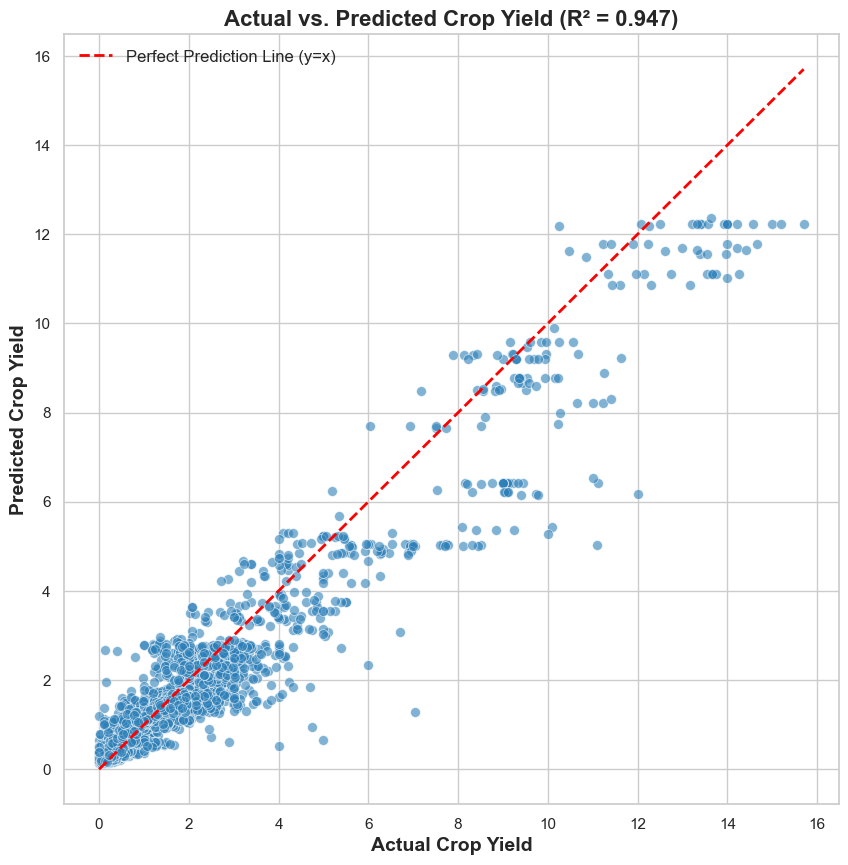

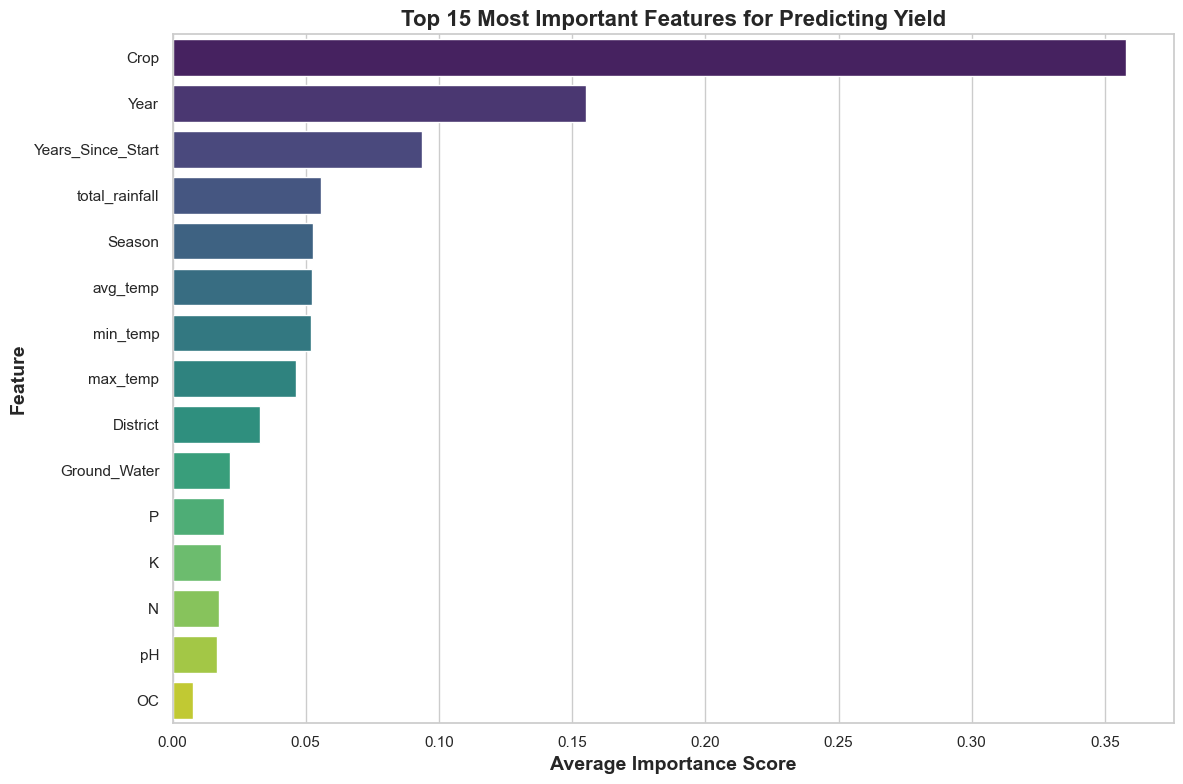

In [43]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting Visualization Generation ---")

# --- Step 1: Load Model Package and Data ---
try:
    # Load the dictionary containing all trained models
    with open('ultimate_blending_model_package.pkl', 'rb') as f:
        model_package = pickle.load(f)
    
    # Load the master dataset to get the true yield values
    merged_df = pd.read_csv('master_dataset_complete.csv')
    
    print("[INFO] Successfully loaded model package and master dataset.")
except FileNotFoundError as e:
    print(f"[ERROR] Could not find a required file: {e}. Please ensure both files are in the same directory.")
    exit()

# --- Step 2: Recreate Out-of-Fold (OOF) Predictions for Plotting ---
print("[INFO] Recreating out-of-fold predictions for visualization...")

# Extract the models
lgbm_model = model_package['lgbm']
xgb_model = model_package['xgb']
cat_model = model_package['cat']
meta_model = model_package['meta_model']

# Recreate the preprocessed data (as done in the training script)
min_year = merged_df['Year'].min()
merged_df['Years_Since_Start'] = merged_df['Year'] - min_year
categorical_cols = ['District', 'Crop', 'Season']
for col in categorical_cols:
    le = pd.factorize(merged_df[col])[0]
    merged_df[col] = le

X = merged_df.drop(['Yield', 'Production', 'Area', 'State'], axis=1)
y_true = merged_df['Yield']

# Create the meta-features (predictions from base models)
meta_features = pd.DataFrame({
    'lgbm_pred': lgbm_model.predict(X),
    'xgb_pred': xgb_model.predict(X),
    'cat_pred': cat_model.predict(X)
})

# Get the final predictions from the meta-model
y_predicted = meta_model.predict(meta_features)

# --- Step 3: Generate and Save Visualizations ---
print("[INFO] Generating and saving plots...")

# Set a professional plot style
sns.set_theme(style="whitegrid")

# --- Plot 1: Actual vs. Predicted Yield ---
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_true, y=y_predicted, alpha=0.6, s=50, color='#2c7fb8')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', lw=2, color='red', label='Perfect Prediction Line (y=x)')
plt.xlabel("Actual Crop Yield", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Crop Yield", fontsize=14, fontweight='bold')
plt.title("Actual vs. Predicted Crop Yield (R² = 0.947)", fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)

# --- Plot 2: Aggregated Feature Importance ---
# We average the importance from our powerful base models
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'lgbm': lgbm_model.feature_importances_,
    'xgb': xgb_model.feature_importances_,
    'cat': cat_model.feature_importances_
})

# Normalize importances so they are comparable
for col in ['lgbm', 'xgb', 'cat']:
    feature_importances[col] = feature_importances[col] / feature_importances[col].sum()

# Calculate the mean importance
feature_importances['mean_importance'] = feature_importances[['lgbm', 'xgb', 'cat']].mean(axis=1)
feature_importances = feature_importances.sort_values('mean_importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='mean_importance', y='feature', data=feature_importances, palette='viridis')
plt.xlabel("Average Importance Score", fontsize=14, fontweight='bold')
plt.ylabel("Feature", fontsize=14, fontweight='bold')
plt.title("Top 15 Most Important Features for Predicting Yield", fontsize=16, fontweight='bold')
plt.tight_layout()

print("\n--- Visualization Generation Complete ---")
